In [1]:
! pip install simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 MB 11.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import string
import spacy
from spacy.lang.it import Italian
from sklearn import metrics
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import simplemma

parser = Italian()
punctuations = string.punctuation

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('italian'))
stemmer = SnowballStemmer('italian')

# function used to perform preprocessing, used in the TfIdfVectorizer function
def preprocessing_text(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    mytokens = [word.lower() for word in mytokens]

    # remove URL \ url
    mytokens = [re.sub(r"URL|url", "", token) for token in mytokens]

    # remove @user
    mytokens = [re.sub(r'@\w+\s*', "", token) for token in mytokens]

    # remove words with numbers
    mytokens = [re.sub(r'\b\w*\d\w*\b', "", token) for token in mytokens]
    mytokens = [re.sub(r"\.{2,4}", "", token) for token in mytokens]

    # remove extra whitespaces
    mytokens = [re.sub(r"\s+", "", token) for token in mytokens]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = [simplemma.lemmatize(token, lang='it') for token in mytokens]

    mytokens = [stemmer.stem(token) for token in mytokens]

    return mytokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# function used to evaluate the classifier on the test sets

def evaluating_results(X_test, y_test, classifier):
    predicted = classifier.predict(X_test)
    predicted = [int(x) for x in predicted]

    acc = metrics.accuracy_score(y_test, predicted)
    print("Accuracy:", acc)
    precision = metrics.precision_score(y_test, predicted, average='macro')
    recall = metrics.recall_score(y_test, predicted, average='macro')
    fm = metrics.f1_score(y_test, predicted, average='macro')
    print("P={0}, R={1}, F1={2}".format(precision, recall, fm))
    print("======================================================")
    print(metrics.classification_report(y_test, predicted, digits=2))

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, predicted)
    print(cm)

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()

In [6]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(tokenizer = preprocessing_text, lowercase = True)

# training set
d = pd.read_csv('./trainingset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
d=d.drop(0)

task_label = "hs"

X_train = d['text'] # the features
y_train = d[task_label] # the labels
print(d.info)

# test set - tweets
t = pd.read_csv('./testset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
X_test = t['text'] # the features
y_test = t[task_label] # the labels

# test set - news
t_news = pd.read_csv('./testset_news.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')

X_test_news = t_news['text']
y_test_news = t_news[task_label]

<bound method DataFrame.info of         id                                               text hs st
1     2066  È terrorismo anche questo, per mettere in uno ...  0  0
2     2045  @user @user infatti finché ci hanno guadagnato...  0  0
3       61  Corriere: Tangenti, Mafia Capitale dimenticata...  0  0
4     1259  @user ad uno ad uno, perché quando i migranti ...  0  0
5      949  Il divertimento del giorno? Trovare i patrioti...  0  0
...    ...                                                ... .. ..
6833  9340  Gli stati nazionali devono essere pronti a rin...  0  0
6834  9121  Il ministro dell'interno della Germania #Horst...  0  0
6835  8549  #Salvini: In Italia troppi si sono montati la ...  0  0
6836  9240  @user @user Chi giubila in buona fede non ha c...  0  0
6837  8000  I giovani cristiani in #Etiopia sono indotti d...  0  1

[6837 rows x 4 columns]>


In [7]:
X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)
X_test_news = vector.transform(X_test_news)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Undersample of the training set with near miss algorithm

In [8]:
from collections import Counter
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot

undersample = NearMiss(version=2, n_neighbors=5)


X_undersampled, y_undersampled  = undersample.fit_resample(X_train, y_train)
counter = Counter(y_undersampled)
print(counter)

Counter({'0': 2766, '1': 2766})


Oversample of the training set with the SMOTE algorithm

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train)

Counter(y_smote)

Counter({'0': 4071, '1': 4071})

Find the best value of K for the original training set, then train and evaluate the classifier

Maximum F1: 0.73 at K = 500


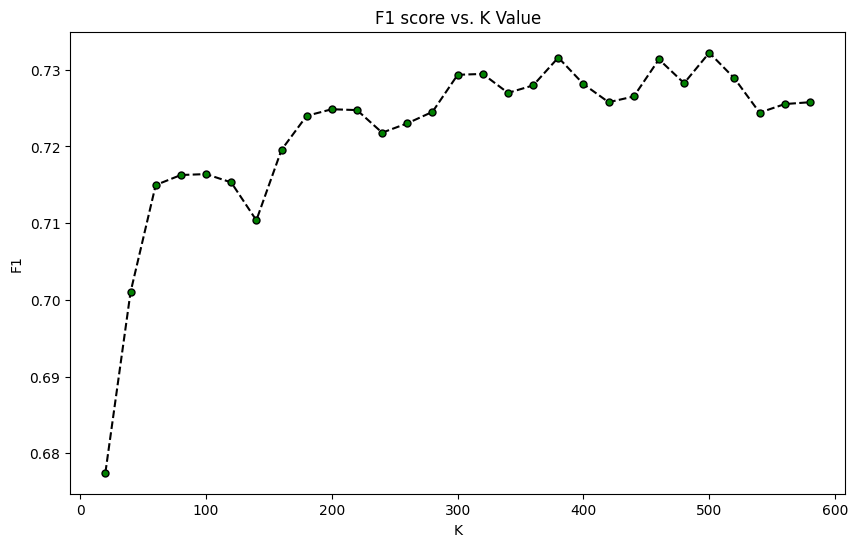

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

f_score = []

for i in range(20,600, 20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat, average='macro'))


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(20,600, 20), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*20 + 20)


TWEETS - ORIGINAL DATASET
Accuracy: 0.7371338083927158
P=0.7516701993507016, R=0.7352634298297978, F1=0.7322252364093369
              precision    recall  f1-score   support

           0       0.69      0.86      0.77       641
           1       0.81      0.61      0.70       622

    accuracy                           0.74      1263
   macro avg       0.75      0.74      0.73      1263
weighted avg       0.75      0.74      0.73      1263

[[551  90]
 [242 380]]


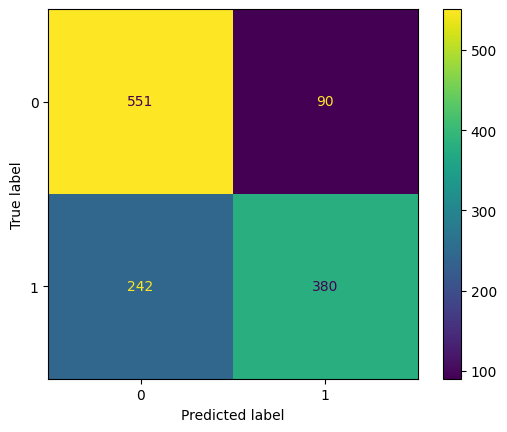

In [12]:
classifier = KNeighborsClassifier(n_neighbors=500)

classifier.fit(X_train, y_train)

print("TWEETS - ORIGINAL DATASET")
evaluating_results(X_test, y_test, classifier)

NEWS - ORIGINAL DATASET
Accuracy: 0.738
P=0.768154761904762, R=0.6560470392628899, F1=0.6604088573665354
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       319
           1       0.81      0.36      0.50       181

    accuracy                           0.74       500
   macro avg       0.77      0.66      0.66       500
weighted avg       0.76      0.74      0.71       500

[[304  15]
 [116  65]]


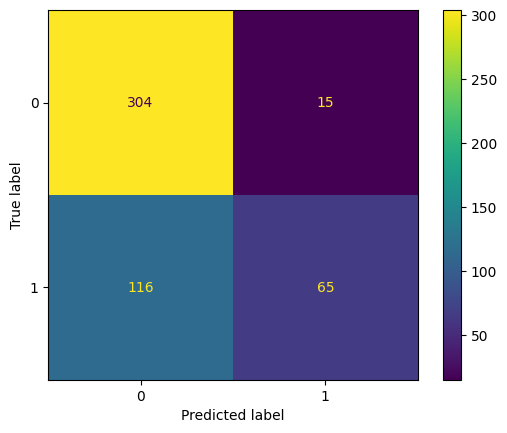

In [13]:
print("NEWS - ORIGINAL DATASET")
evaluating_results(X_test_news, y_test_news, classifier)

Find the best value of K for the undersampled dataset

Maximum F1: 0.66 at K = 60


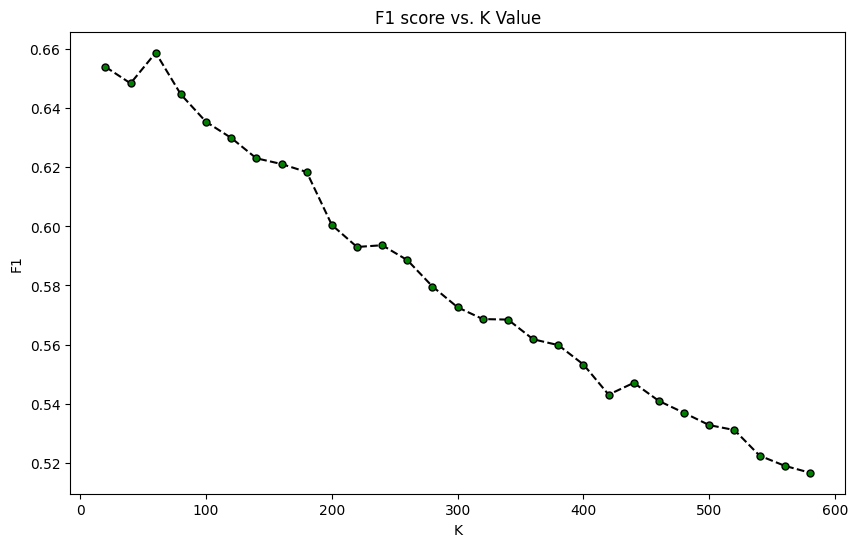

In [14]:
f_score = []

for i in range(20,600, 20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_undersampled, y_undersampled)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat, average='macro'))


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(20,600, 20), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*20 + 20)

TWEET - UNDERSAMPLED DATASET
Accuracy: 0.6682501979414094
P=0.6943444605432786, R=0.6709033313101013, F1=0.6588178862449059
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       641
           1       0.62      0.85      0.72       622

    accuracy                           0.67      1263
   macro avg       0.69      0.67      0.66      1263
weighted avg       0.70      0.67      0.66      1263

[[317 324]
 [ 95 527]]


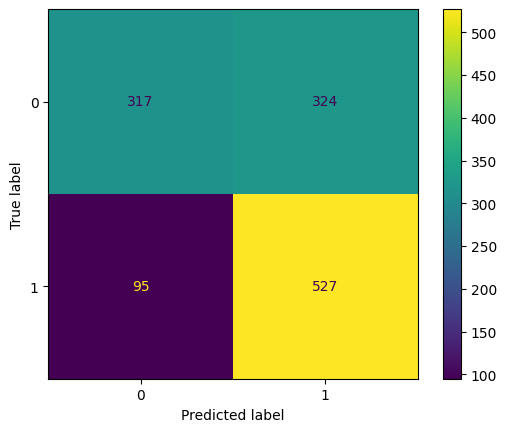

In [15]:
print("TWEET - UNDERSAMPLED DATASET")

classifier = KNeighborsClassifier(n_neighbors=60)
classifier.fit(X_undersampled, y_undersampled)
evaluating_results(X_test, y_test, classifier)

NEWS - UNDERSAMPLED DATASET
Accuracy: 0.708
P=0.6836178840564576, R=0.6827274459204351, F1=0.6831597222222223
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       319
           1       0.60      0.59      0.59       181

    accuracy                           0.71       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.71      0.71      0.71       500

[[247  72]
 [ 74 107]]


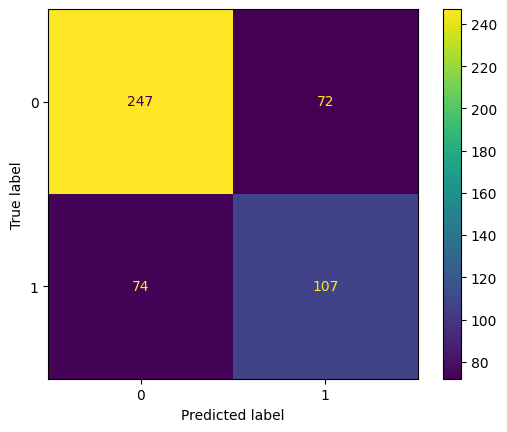

In [16]:
print("NEWS - UNDERSAMPLED DATASET")

evaluating_results(X_test_news, y_test_news, classifier)

Find the best value of K for oversampled training set

Maximum F1: 0.33 at K = 20


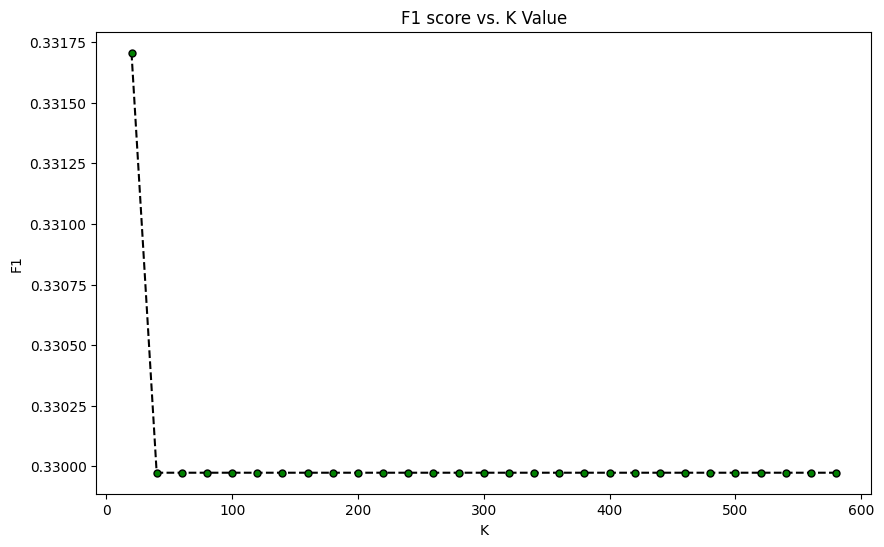

In [17]:
f_score = []

for i in range(20,600, 20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_smote, y_smote)
    yhat = neigh.predict(X_test)

    yhat =[int(x) for x in yhat]

    f_score.append(metrics.f1_score(y_test, yhat, average='macro'))


import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(20,600, 20), f_score, color = 'black',linestyle='dashed',
         marker='o',markerfacecolor='green', markersize=5)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1')
print("Maximum F1:", round(max(f_score), 2 ) ,"at K =", f_score.index(max(f_score))*20 + 20)


TWEET - SMOTED DATASET
Accuracy: 0.4924782264449723
P=0.24623911322248615, R=0.5, F1=0.32997347480106104
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       641
           1       0.49      1.00      0.66       622

    accuracy                           0.49      1263
   macro avg       0.25      0.50      0.33      1263
weighted avg       0.24      0.49      0.33      1263

[[  0 641]
 [  0 622]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

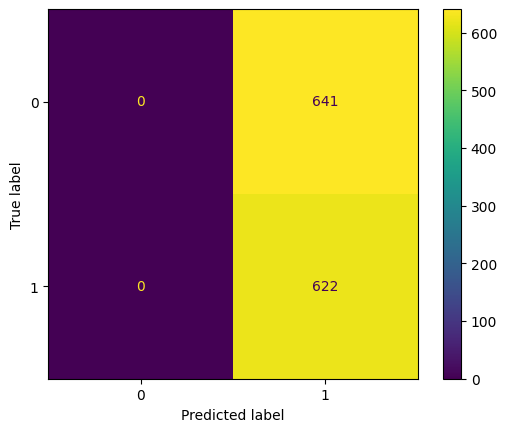

In [20]:
print("TWEET - SMOTED DATASET")

classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_smote, y_smote)
evaluating_results(X_test, y_test, classifier)

NEWS - SMOTED DATASET
Accuracy: 0.362
P=0.181, R=0.5, F1=0.26578560939794416
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       319
           1       0.36      1.00      0.53       181

    accuracy                           0.36       500
   macro avg       0.18      0.50      0.27       500
weighted avg       0.13      0.36      0.19       500

[[  0 319]
 [  0 181]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

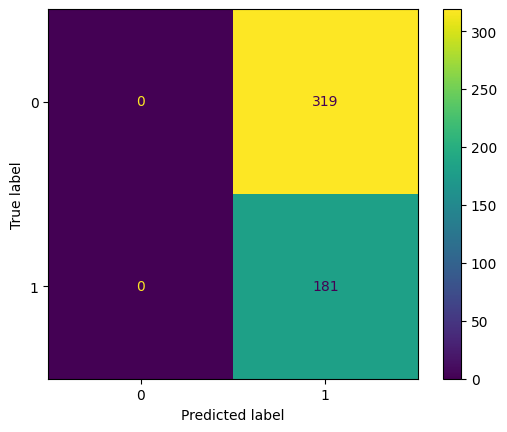

In [21]:
print("NEWS - SMOTED DATASET")
evaluating_results(X_test_news, y_test_news, classifier)